# 实验三：傅里叶描述子对手写数字识别

## 实验原理

### 傅里叶描述子 (Fourier Descriptor) 概述
傅里叶描述子是一种利用傅里叶变换来描述图像轮廓特征的方法。通过对数字轮廓进行傅里叶变换，将空间域中的轮廓信息转换为频域的傅里叶系数，用少量的低频系数即可有效表示轮廓形状。

### 核心优势
- **轮廓形状描述**：有效捕捉物体的轮廓特征
- **特征压缩**：用少量傅里叶系数表示完整轮廓，实现降维
- **旋转不变性**：通过选择适当的傅里叶系数可实现部分旋转不变性
- **尺度归一化**：通过幅值归一化使特征对缩放不敏感

### 数学原理

#### 第一步：轮廓提取
从二值化的数字图像中提取边界：
- 二值化：灰度值 > 阈值(127) → 1，否则 → 0
- 轮廓检测：找连续的边界像素
- 链码表示：$(x_0, y_0), (x_1, y_1), \ldots, (x_{N-1}, y_{N-1})$

#### 第二步：复数表示
将轮廓点转换为复数形式：
$$z_n = x_n + j \cdot y_n, \quad n = 0, 1, \ldots, N-1$$

其中 $x_n, y_n$ 是第 $n$ 个轮廓点的坐标，$j$ 是虚数单位。

#### 第三步：离散傅里叶变换 (DFT)
对轮廓序列进行快速傅里叶变换：
$$F(u) = \sum_{n=0}^{N-1} z_n e^{-j \cdot 2\pi \cdot u \cdot n / N}, \quad u = 0, 1, \ldots, N-1$$

每个 $F(u)$ 称为傅里叶系数，包含幅值和相位。

#### 第四步：傅里叶描述子提取
保留前 $k$ 个傅里叶系数的幅值作为描述子：
$$\text{FD} = [|F(0)|, |F(1)|, \ldots, |F(k-1)|]$$

- $|F(0)|$ 表示轮廓的中心位置（直流分量）
- $|F(1)|, |F(2)|, \ldots$ 表示轮廓的形状信息（交流分量）
- 低频分量捕捉主要形状，高频分量描述细节

#### 第五步：归一化
对特征向量进行幅值归一化，使其对缩放不敏感：
$$\text{FD}_{\text{norm}} = \frac{\text{FD}}{\max(\text{FD})}$$

归一化后特征值在 [0, 1] 范围内。

#### 第六步：维度压缩比
$$\text{Compression Ratio} = \frac{k}{N}$$

其中 $N$ 是轮廓点数，$k$ 是保留的傅里叶系数个数。

### 分类阶段
使用 k-NN 分类器（k=1，即最近邻）：
$$\hat{y}_{\text{test}} = \arg\min_i \|FD_{\text{test}} - FD_{\text{train},i}\|_2$$

其中欧几里得距离衡量两个傅里叶描述子的相似度。

## 实验步骤
1. **加载数据** - 读取MNIST手写数字数据集
2. **轮廓提取** - 对每个数字进行二值化和边界检测
3. **傅里叶变换** - 对轮廓点进行FFT变换
4. **特征提取** - 保留前k个傅里叶系数的幅值
5. **特征归一化** - 将特征向量归一化到[0,1]范围
6. **最近邻分类** - 使用k-NN分类器进行预测
7. **性能评估** - 计算准确率、混淆矩阵等指标

## 关键参数
- **NUM_DESCRIPTORS** = 20：保留的傅里叶系数个数
- **二值化阈值** = 127：灰度值的分割阈值
- **分类器** = k-NN（k=1）：使用最近邻分类
- **距离度量** = 欧几里得距离
- **训练集大小** = 60,000张图像
- **测试集大小** = 10,000张图像
- **图像尺寸** = 28 × 28 像素

In [1]:
import cv2
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

NUM_DESCRIPTORS = 20

print("="*70)
print("傅里叶描述子手写数字识别")
print("="*70)

傅里叶描述子手写数字识别


In [2]:
print("\n加载MNIST数据集...")
print("MNIST简介：")
print("   数字类别：0-9，共10类")
print("   训练集：60,000张28×28灰度图像")
print("   测试集：10,000张28×28灰度图像")
print("   像素值范围：[0, 255]\n")

transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print(f"训练集大小: {len(trainset)} 张")
print(f"测试集大小: {len(testset)} 张")


加载MNIST数据集...
MNIST简介：
   数字类别：0-9，共10类
   训练集：60,000张28×28灰度图像
   测试集：10,000张28×28灰度图像
   像素值范围：[0, 255]

训练集大小: 60000 张
测试集大小: 10000 张


In [3]:
def extract_contour(image):
    """提取图像轮廓
    
    处理步骤：
    1. 二值化：灰度值>127的像素设为255，其余为0
    2. 轮廓检测：使用OpenCV的轮廓检测算法
    3. 返回最大面积的轮廓（对应数字区域）
    """
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def get_contour_chain_code(contour):
    """获取轮廓链码表示
    
    将轮廓点提取为坐标序列
    链码：(x_0, y_0), (x_1, y_1), ..., (x_{N-1}, y_{N-1})
    """
    if contour is None or len(contour) < 3:
        return np.array([])
    
    contour = contour.squeeze()
    if len(contour.shape) < 2:
        return np.array([])
    
    return contour

def compute_fourier_descriptor(contour_points):
    """计算傅里叶描述子
    
    算法步骤：
    1. 将轮廓点转换为复数表示：z_n = x_n + j*y_n
    2. 进行快速傅里叶变换 (FFT)：F(u) = FFT(z_n)
    3. 提取前 NUM_DESCRIPTORS 个傅里叶系数的幅值
    4. 归一化到 [0, 1] 范围
    
    傅里叶系数的含义：
    - F(0)：直流分量，表示轮廓中心
    - F(1), F(2), ...：交流分量，描述轮廓形状
    - 低频分量：主要形状特征
    - 高频分量：细节特征
    """
    if len(contour_points) < 3:
        return np.zeros(NUM_DESCRIPTORS, dtype=np.float64)
    
    # 将轮廓点转为复数形式
    contour_complex = contour_points[:, 0] + 1j * contour_points[:, 1]
    # 进行FFT变换
    fourier_result = np.fft.fft(contour_complex)
    
    # 提取幅值
    n_desc = min(NUM_DESCRIPTORS, len(fourier_result) // 2)
    descriptors = np.abs(fourier_result[:n_desc]).astype(np.float64)
    
    # 填充不足的维度
    if len(descriptors) < NUM_DESCRIPTORS:
        pad_width = NUM_DESCRIPTORS - len(descriptors)
        descriptors = np.pad(descriptors, (0, pad_width), mode='constant', constant_values=0)
    
    return descriptors[:NUM_DESCRIPTORS]

def extract_fourier_features(image_tensor):
    """从图像提取傅里叶描述子特征
    
    完整步骤：
    1. 归一化像素值到 [0, 255]
    2. 提取数字轮廓
    3. 获取轮廓链码表示
    4. 计算傅里叶描述子
    5. 幅值归一化
    
    返回值：20维的傅里叶描述子特征向量
    """
    img = (image_tensor.numpy() * 255).astype(np.uint8)
    img = img.squeeze()
    
    # 步骤1: 提取轮廓
    contour = extract_contour(img)
    if contour is None:
        return np.zeros(NUM_DESCRIPTORS, dtype=np.float64)
    
    # 步骤2: 获取链码
    contour_points = get_contour_chain_code(contour)
    if len(contour_points) < 3:
        return np.zeros(NUM_DESCRIPTORS, dtype=np.float64)
    
    # 步骤3: 计算傅里叶描述子
    descriptors = compute_fourier_descriptor(contour_points)
    
    # 步骤4: 幅值归一化
    if np.max(descriptors) > 0:
        descriptors = descriptors / np.max(descriptors)
    
    return descriptors.astype(np.float64)

print("\n傅里叶描述子特征提取函数已定义")


傅里叶描述子特征提取函数已定义


In [4]:
print("\n从训练集提取傅里叶描述子...")
print("这个过程需要对60,000张图像进行：")
print("   轮廓提取 → 傅里叶变换 → 特征提取\n")

train_features = []
train_labels = []

for images, labels in trainloader:
    for img, label in zip(images, labels):
        feature = extract_fourier_features(img)
        train_features.append(feature)
        train_labels.append(label.item())

train_features = np.array(train_features)
train_labels = np.array(train_labels)
print(f"训练特征形状: {train_features.shape}")
print(f"   样本数: {train_features.shape[0]}")
print(f"   特征维度: {train_features.shape[1]} (傅里叶系数个数)")


从训练集提取傅里叶描述子...
这个过程需要对60,000张图像进行：
   轮廓提取 → 傅里叶变换 → 特征提取

训练特征形状: (60000, 20)
   样本数: 60000
   特征维度: 20 (傅里叶系数个数)


In [5]:
print("\n从测试集提取傅里叶描述子...")
test_features = []
test_labels = []

for images, labels in testloader:
    for img, label in zip(images, labels):
        feature = extract_fourier_features(img)
        test_features.append(feature)
        test_labels.append(label.item())

test_features = np.array(test_features)
test_labels = np.array(test_labels)
print(f"测试特征形状: {test_features.shape}")


从测试集提取傅里叶描述子...
测试特征形状: (10000, 20)


In [6]:
class FourierClassifier:
    """基于傅里叶描述子的最近邻分类器
    
    分类原理（k-NN, k=1）：
    
    给定测试样本傅里叶描述子 FD_test：
    
    1. 计算与所有训练样本的距离
       d_i = ||FD_test - FD_train_i||_2
    
    2. 找最近邻
       i_nearest = argmin(d_i)
    
    3. 返回其标签
       label = y_train[i_nearest]
    """
    def __init__(self):
        self.train_features = None
        self.train_labels = None
    
    def fit(self, X_train, y_train):
        """存储训练样本
        
        最近邻分类器无需参数学习，只需存储训练数据
        
        参数：
            X_train: 训练集特征矩阵，形状 (n_samples, n_features)
            y_train: 训练集标签向量，形状 (n_samples,)
        """
        self.train_features = X_train
        self.train_labels = y_train
    
    def predict(self, X_test):
        """进行预测
        
        最近邻分类算法：
        对每个测试样本 x_test：
            1. 计算到所有训练样本的欧几里得距离：
               distance_i = sqrt(sum((x_test - x_train_i)^2))
            
            2. 找到最小距离对应的训练样本：
               nearest_idx = argmin(distance_i)
            
            3. 返回该训练样本的标签：
               prediction = y_train[nearest_idx]
        
        参数：
            X_test: 测试集特征矩阵，形状 (n_test_samples, n_features)
        
        返回值：
            predictions: 预测标签向量，形状 (n_test_samples,)
        """
        predictions = []
        
        for test_feature in X_test:
            # 计算测试样本到所有训练样本的距离
            distances = np.linalg.norm(self.train_features - test_feature, axis=1)
            # 选择距离最近的训练样本
            nearest_idx = np.argmin(distances)
            # 返回该样本的标签
            predictions.append(self.train_labels[nearest_idx])
        
        return np.array(predictions)

print("\n训练傅里叶描述子分类器...")
clf = FourierClassifier()
clf.fit(train_features, train_labels)
print("训练完成（0.0 秒 - 仅存储数据，无参数学习）")


训练傅里叶描述子分类器...
训练完成（0.0 秒 - 仅存储数据，无参数学习）


In [7]:
print("\n在测试集上进行预测...")
test_predictions = clf.predict(test_features)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"\n{'='*70}")
print(f"{'预测完成':^70}")
print(f"{'='*70}")
print(f"测试准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"总测试样本: {len(test_labels)}")
print(f"正确分类: {np.sum(test_predictions == test_labels)}")
print(f"错误分类: {np.sum(test_predictions != test_labels)}")
print(f"{'='*70}\n")


在测试集上进行预测...

                                 预测完成                                 
测试准确率: 0.5026 (50.26%)
总测试样本: 10000
正确分类: 5026
错误分类: 4974



In [8]:
print("详细分类报告")
print("(精度、召回率、F1分数)\n")
print(classification_report(test_labels, test_predictions, digits=4))

详细分类报告
(精度、召回率、F1分数)

              precision    recall  f1-score   support

           0     0.7213    0.7235    0.7224       980
           1     0.8767    0.8705    0.8736      1135
           2     0.3106    0.3304    0.3202      1032
           3     0.6405    0.6069    0.6233      1010
           4     0.5119    0.5265    0.5191       982
           5     0.4201    0.4215    0.4208       892
           6     0.3196    0.3079    0.3137       958
           7     0.4231    0.4173    0.4202      1028
           8     0.3241    0.2998    0.3115       974
           9     0.4267    0.4618    0.4436      1009

    accuracy                         0.5026     10000
   macro avg     0.4975    0.4966    0.4968     10000
weighted avg     0.5034    0.5026    0.5028     10000



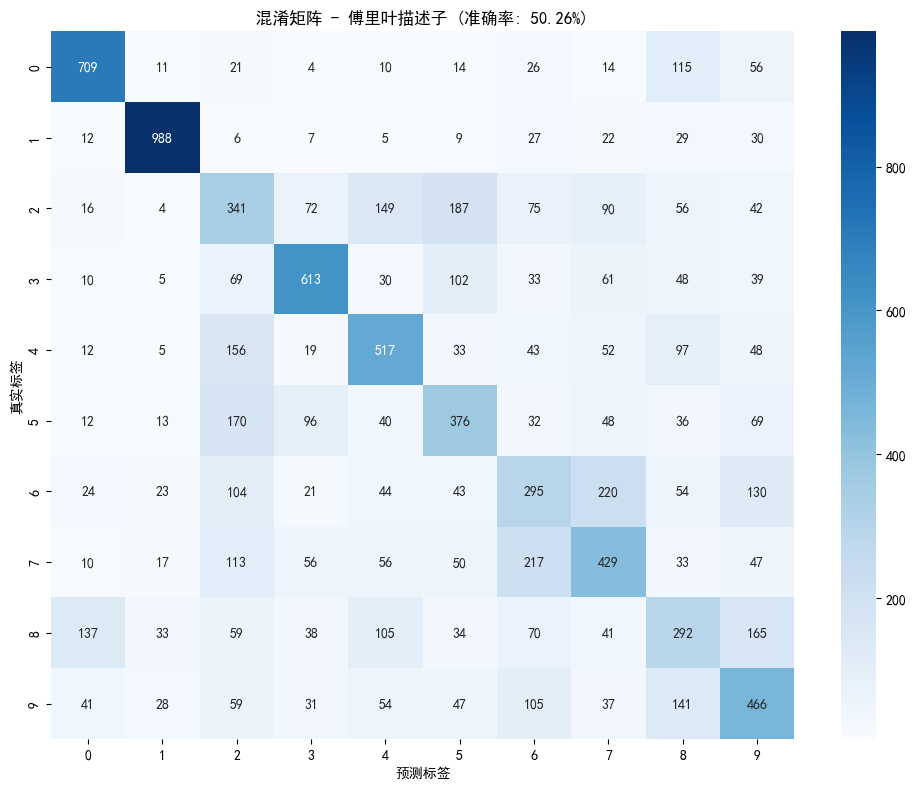

In [9]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'混淆矩阵 - 傅里叶描述子 (准确率: {accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()

In [10]:
print("\n各数字识别准确率\n")
for digit in range(10):
    mask = test_labels == digit
    if np.sum(mask) > 0:
        digit_accuracy = accuracy_score(test_labels[mask], test_predictions[mask])
        count = np.sum(mask)
        correct = np.sum(test_predictions[mask] == digit)
        print(f"数字{digit}: 准确率 = {digit_accuracy:.4f} ({int(correct)}/{int(count)})")


各数字识别准确率

数字0: 准确率 = 0.7235 (709/980)
数字1: 准确率 = 0.8705 (988/1135)
数字2: 准确率 = 0.3304 (341/1032)
数字3: 准确率 = 0.6069 (613/1010)
数字4: 准确率 = 0.5265 (517/982)
数字5: 准确率 = 0.4215 (376/892)
数字6: 准确率 = 0.3079 (295/958)
数字7: 准确率 = 0.4173 (429/1028)
数字8: 准确率 = 0.2998 (292/974)
数字9: 准确率 = 0.4618 (466/1009)



显示分类错误的样本...


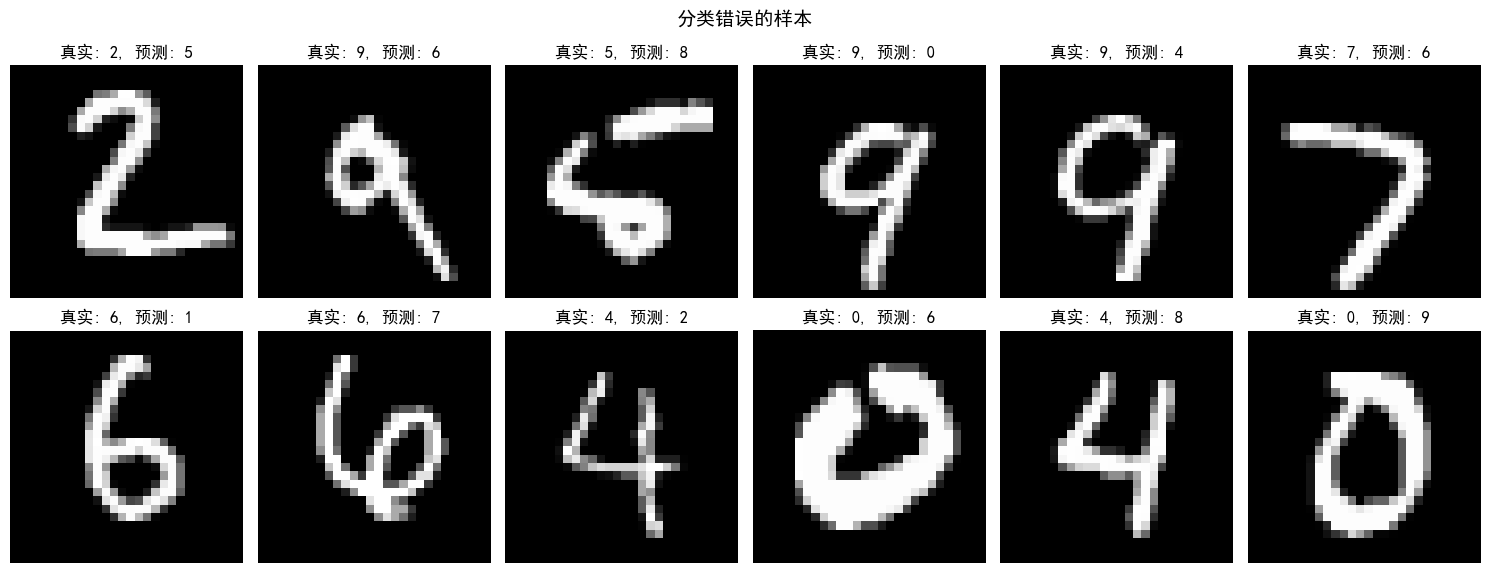

In [11]:
print("\n显示分类错误的样本...")
errors_idx = np.where(test_predictions != test_labels)[0]

if len(errors_idx) > 0:
    n_errors = min(12, len(errors_idx))
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))

    # 加载所有测试图像
    all_test_images = []
    for images, labels in testloader:
        for img in images:
            all_test_images.append(img.numpy().squeeze())

    for i, idx in enumerate(errors_idx[:n_errors]):
        ax = axes[i // 6, i % 6]
        img_np = all_test_images[idx]
        ax.imshow(img_np, cmap='gray')
        ax.set_title(f"真实: {test_labels[idx]}, 预测: {test_predictions[idx]}")
        ax.axis('off')

    plt.suptitle('分类错误的样本', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("没有分类错误的样本")


显示分类正确的样本...


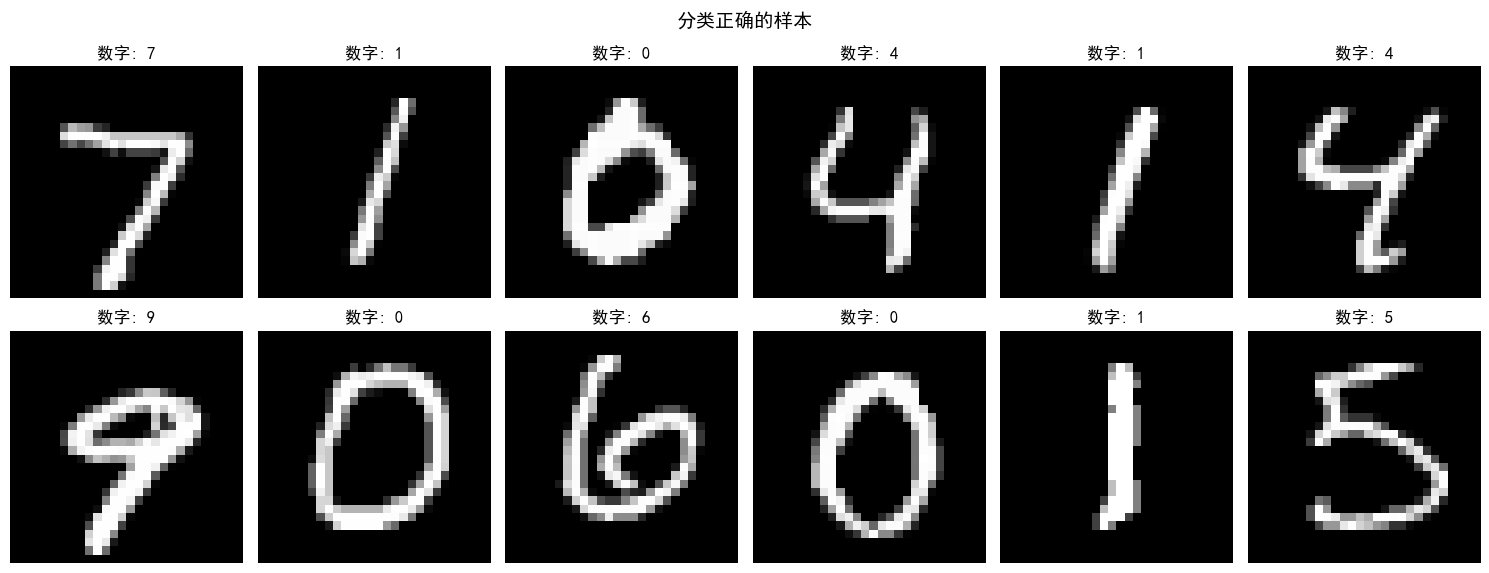

In [12]:
print("\n显示分类正确的样本...")
correct_idx = np.where(test_predictions == test_labels)[0]

if len(correct_idx) > 0:
    n_correct = min(12, len(correct_idx))
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))

    # 加载所有测试图像
    all_test_images = []
    for images, labels in testloader:
        for img in images:
            all_test_images.append(img.numpy().squeeze())

    for i, idx in enumerate(correct_idx[:n_correct]):
        ax = axes[i // 6, i % 6]
        img_np = all_test_images[idx]
        ax.imshow(img_np, cmap='gray')
        ax.set_title(f"数字: {test_labels[idx]}")
        ax.axis('off')

    plt.suptitle('分类正确的样本', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("没有分类正确的样本")

In [13]:
print("\n傅里叶描述子数学原理总结")
print("="*70)
summary = """
傅里叶描述子数学理论总结
=====================

1. 轮廓提取
   从二值化的数字图像中提取边界
   表示：(x_0, y_0), (x_1, y_1), ..., (x_{N-1}, y_{N-1})

2. 复数表示
   将轮廓点转换为复数形式：
   z_n = x_n + j*y_n，n = 0, 1, ..., N-1

3. 离散傅里叶变换 (DFT)
   对轮廓序列进行FFT：
   F(u) = sum(z_n * exp(-j*2*pi*u*n/N))，u = 0, 1, ..., N-1

4. 傅里叶描述子（系数）
   提取前k个傅里叶系数的幅值：
   FD = [|F(0)|, |F(1)|, ..., |F(k-1)|]

5. 幅值归一化
   使特征对缩放不敏感：
   FD_norm = FD / max(FD)

6. k-NN分类
   使用欧几里得距离进行最近邻分类：
   label = argmin_i ||FD_test - FD_train_i||_2

关键参数：
   - NUM_DESCRIPTORS = 20
   - 二值化阈值 = 127
   - 距离度量 = 欧几里得距离
   - 分类器 = k-NN (k=1)
"""
print(summary)
print("="*70)


傅里叶描述子数学原理总结

傅里叶描述子数学理论总结

1. 轮廓提取
   从二值化的数字图像中提取边界
   表示：(x_0, y_0), (x_1, y_1), ..., (x_{N-1}, y_{N-1})

2. 复数表示
   将轮廓点转换为复数形式：
   z_n = x_n + j*y_n，n = 0, 1, ..., N-1

3. 离散傅里叶变换 (DFT)
   对轮廓序列进行FFT：
   F(u) = sum(z_n * exp(-j*2*pi*u*n/N))，u = 0, 1, ..., N-1

4. 傅里叶描述子（系数）
   提取前k个傅里叶系数的幅值：
   FD = [|F(0)|, |F(1)|, ..., |F(k-1)|]

5. 幅值归一化
   使特征对缩放不敏感：
   FD_norm = FD / max(FD)

6. k-NN分类
   使用欧几里得距离进行最近邻分类：
   label = argmin_i ||FD_test - FD_train_i||_2

关键参数：
   - NUM_DESCRIPTORS = 20
   - 二值化阈值 = 127
   - 距离度量 = 欧几里得距离
   - 分类器 = k-NN (k=1)



In [14]:
print("\n实验总结")
print(f"{'='*70}")
print(f"{'傅里叶描述子手写数字识别结果':^70}")
print(f"{'='*70}")
print(f"总测试样本数: {len(test_labels)}")
print(f"正确分类数: {np.sum(test_predictions == test_labels)}")
print(f"错误分类数: {np.sum(test_predictions != test_labels)}")
print(f"\n总体准确率: {accuracy*100:.2f}%")
print(f"\n分析：")
print(f"傅里叶描述子主要用于捕捉轮廓形状。")
print(f"对于手写数字识别，准确率受以下因素影响：")
print(f"   - 不同写法的数字形状差异大")
print(f"   - 某些数字(如6和9)轮廓相似")
print(f"   - 仅使用20维特征可能信息不足")
print(f"{'='*70}")


实验总结
                            傅里叶描述子手写数字识别结果                            
总测试样本数: 10000
正确分类数: 5026
错误分类数: 4974

总体准确率: 50.26%

分析：
傅里叶描述子主要用于捕捉轮廓形状。
对于手写数字识别，准确率受以下因素影响：
   - 不同写法的数字形状差异大
   - 某些数字(如6和9)轮廓相似
   - 仅使用20维特征可能信息不足
